# EDA - Previsão de Energia

In [1]:
import os
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
from unidecode import unidecode
from datetime import timedelta

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
os.chdir('../')

## Leitura dos dados
Lê todos os parquets ignorando a colunas `CNAE`, pois a mesma não está presente em alguns arquivos. 

In [4]:
create_table_sql = """
    SELECT 
        "CNPJ da Carga" AS cnpj_carga, 
        "Capacidade da Carga (MW)" AS capacidade_carga_mw, 
        "Carga" AS carga, 
        "Cidade" AS cidade,
        "Classe do perfil do agente" AS classe_perfil_agente,
        "Consumo de energia ajustado da parcela cativa da carga parcialmente livre - MWh (RC_CAT c,j)" AS consumo_parcela_cativa,
        "Consumo de energia ajustado de uma parcela de carga - MWh (RC c,j)" AS consumo_parcela_carga,
        "Consumo de energia no ponto de conexão da parcela de carga - MWh (MED_C c,j)" AS consumo_ponto_conexao_parcela_carga,
        "Consumo no Ambiente Livre da parcela de carga - MWh (RC_AL c,j)" AS consumo_ambiente_livre_parcela_carga,
        "Cód. Carga" AS cod_carga, 
        "Cód. Perfil" AS cod_perfil, 
        "Cód. Perfil Distribuidora" AS cod_perfil_distribuidora, 
        "Data" AS data,
        "Data de Migração" AS data_migracao, 
        "Estado" AS estado,
        "HH" AS hora, 
        "Nome Empresarial" AS nome_empresarial,
        "Ramo de Atividade" AS ramo_atividade, 
        "Sigla" AS sigla, 
        "Sigla Perfil Distribuidora" AS sigla_perfil_distribuidora,
        "Submercado" AS submercado  
    FROM parquet_scan('data/raw/*.parquet')
"""

In [5]:
consumo = duckdb.sql(create_table_sql).df()

In [67]:
consumo.head()

,classe_perfil_agente,consumo_parcela_carga,consumo_ponto_conexao_parcela_carga,consumo_ambiente_livre_parcela_carga,cod_perfil,data,data_migracao,hora,sigla
0,Consumidor Especial,"0,11349000000000001","0,10970899999999999","0,11349000000000001",96928,2021-04-01,2020-08-01 03:00:00,"6,0",FCA ESPECIAL
1,Consumidor Especial,"0,122617","0,118656","0,122617",96928,2021-04-01,2020-08-01 03:00:00,"7,0",FCA ESPECIAL
2,Consumidor Especial,"0,13808399999999998","0,133792","0,13808399999999998",96928,2021-04-01,2020-08-01 03:00:00,"8,0",FCA ESPECIAL
3,Consumidor Especial,"0,148534","0,143558","0,148534",96928,2021-04-01,2020-08-01 03:00:00,"5,0",FCA ESPECIAL
4,Consumidor Especial,"0,148632","0,144137","0,148632",96928,2021-04-01,2020-08-01 03:00:00,"13,0",FCA ESPECIAL


# Dataprep

In [7]:
def list_columns_repeated_classes(dataframe):
  """
    List all columns with repeated classes in data
    
    Parameters
    -------------
    dataframe: pd.dataframe
        A pandas dataframe containing the data.

    Returns
    -------------
    columns_unwanted: list
        A list of variables unwanted according to repeated classes criterion.
  """
  columns_unwanted = []
  for column in dataframe.columns:
    value_counts_ = dataframe[column].value_counts()
    if dataframe[column].nunique() == 1:
      columns_unwanted.append(column)
    elif (value_counts_.values[0] == value_counts_).all() and (value_counts_.shape[0] == 3):
      columns_unwanted.append(column)
  return columns_unwanted

In [8]:
columns_repeated_class = list_columns_repeated_classes(consumo)

In [9]:
consumo = consumo.drop(columns = columns_repeated_class)

Seleção das variáveis de interesse.

In [21]:
consumo_reduced = consumo[
    [
        'sigla',
        'classe_perfil_agente',
        'data',
        'hora',
        'consumo_ambiente_livre_parcela_carga',
        'consumo_parcela_carga',
        'consumo_ponto_conexao_parcela_carga'
        ]
].copy()

### Transformação das variáveis para float

As variáveis abaixo devem ser analisadas como float, mas estão salvas como string separadas por ",". Iremos transformá-las.

In [23]:
string_to_float_columns = [
    'hora',
    'consumo_ambiente_livre_parcela_carga',
    'consumo_parcela_carga',
    'consumo_ponto_conexao_parcela_carga'
]

In [24]:
consumo_reduced[string_to_float_columns] = consumo_reduced[string_to_float_columns]\
.map(lambda x: x.replace(',', '.'))\
.astype(float)

### Transformação das variáveis de interesse em uma

**Obs.:** Via conhecimento de especialistas, trabalharemos com a soma das variáveis de consumo. No entanto, um estudo mais detalhado pode ser realizado, para isso, devemos resolver um problema de séries temporais multivariado.

In [25]:
consume_columns = consumo_reduced.filter(like = 'consumo').columns.tolist()

In [26]:
consumo_reduced['consumo'] = consumo_reduced.filter(like = 'consumo').sum(axis = 1)

In [27]:
consumo_reduced = consumo_reduced.drop(columns = consume_columns)

In [28]:
consumo_reduced

,sigla,classe_perfil_agente,data,hora,consumo
0,FCA ESPECIAL,Consumidor Especial,2021-04-01,6.0,0.336689
1,FCA ESPECIAL,Consumidor Especial,2021-04-01,7.0,0.363890
2,FCA ESPECIAL,Consumidor Especial,2021-04-01,8.0,0.409960
3,FCA ESPECIAL,Consumidor Especial,2021-04-01,5.0,0.440626
4,FCA ESPECIAL,Consumidor Especial,2021-04-01,13.0,0.441401
...,...,...,...,...,...
65803,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,19.0,1.074097
65804,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,20.0,1.027133
65805,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,21.0,0.994397
65806,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,22.0,1.008769


# Feature Engineering e Análise

### Transformação da série para o diário
Facultativamente decidida para o projeto, outras faixas de tempo podem ser consideradas em estudos futuros.

In [70]:
daily_consume = consumo_reduced\
.groupby(['sigla', 'classe_perfil_agente', 'data'])['consumo']\
.sum()\
.reset_index()

### Análise de dados faltantes
Busca por dados faltantes que causam lacunas na série e podem trazer problemas de quebra do processo estocástico.

Para esta verificação selecionamos as datas iniciais e finais com objetivo de criar uma série (pandas) com todos os dias dos meses ao longo desse intervalo. Em seguida, checamos se há algum valor faltando na nossa série temporal.

In [71]:
first_day = daily_consume['data'].min()
last_day = daily_consume['data'].max()

In [72]:
observational_temporal_interval = (last_day - first_day).days

In [131]:
timestamp_list = [first_day + timedelta(days=x) for x in range(observational_temporal_interval + 1)] 
timestamp_list = pd.Series(timestamp_list)

Identificamos que há um dia faltante na série temporal. Neste caso iremos imputar via interpolação.

In [137]:
missing_date = timestamp_list[~timestamp_list.isin(daily_consume['data'])]

Observamos que não há valores faltantes. Neste caso, interpolação não é necessário.

In [140]:
missing_date

Series([], dtype: datetime64[ns])

### Análise da distribuição de probabilidade

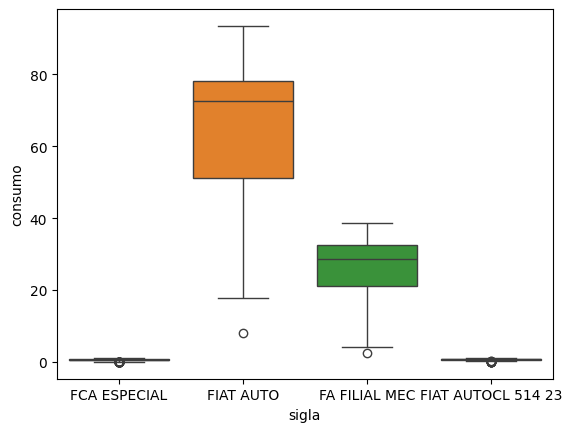

In [143]:
sns.boxplot(data = consumo_reduced, x = 'sigla', y = 'consumo', hue = 'sigla');

# TODO - Analisar histogramas por `sigla`

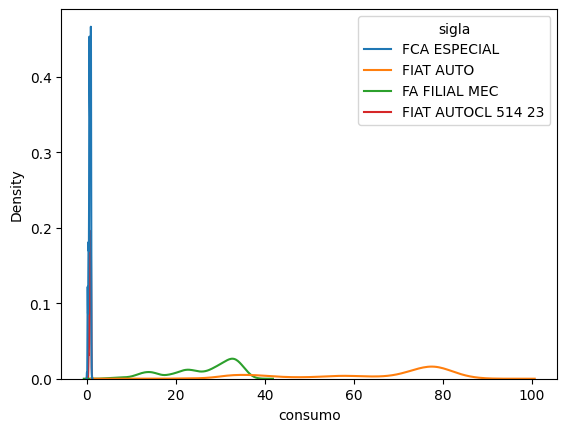

In [146]:
sns.kdeplot(data = consumo_reduced, x = 'consumo', hue = 'sigla', );

## TODO - Feature Engineering

- Feriados: https://github.com/joaopbini/feriados-brasil/tree/master/dados/feriados/nacional/csv